In [13]:
# Enhanced Sheet Music to ABC Notation Model with CLIP Features
# Using CLIP ViT-Base-Patch32, ABC special tokens, data augmentation, and TensorBoard

## Setup and Import Libraries

import os
import json
import re
import torch
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import datetime
import time
import math

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# TensorBoard imports
from torch.utils.tensorboard import SummaryWriter

# Torchvision for transforms
from torchvision import transforms

# HuggingFace Imports
from transformers import CLIPModel, CLIPProcessor
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers.modeling_outputs import BaseModelOutput

# Set device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

# Set up TensorBoard
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(log_dir)
print(f"TensorBoard logs will be saved to {log_dir}")

## Data Loading and Preparation

# Define paths
data_root = "Data"
measures_png_dir = os.path.join(data_root, "measures_pngs")
measures_json_path = os.path.join(data_root, "measures.json")

# Load the JSON data
with open(measures_json_path, 'r') as f:
    measures_data = json.load(f)

# Display some statistics
print(f"Number of songs: {len(measures_data)}")
song_measures_count = {song: len(measures) for song, measures in measures_data.items()}
print(f"Average measures per song: {sum(song_measures_count.values()) / len(song_measures_count)}")

# Sample a song to see its ABC notation
sample_song = list(measures_data.keys())[0]
print(f"Sample song: {sample_song}")
print(f"First 5 measures ABC notation:")
for i, measure in enumerate(measures_data[sample_song][:5]):
    print(f"  Measure {i+1}: {measure}")

## Create Dataset Mapping

# Collect all chord symbols for special tokens
chord_pattern = re.compile(r'"[^"]+"')
all_chords = set()

for song, measures in measures_data.items():
    for measure in measures:
        chords = chord_pattern.findall(measure)
        all_chords.update(chords)

print(f"Found {len(all_chords)} unique chord symbols: {''.join(sorted(all_chords))}")

# Collect other special characters in ABC notation
special_chars = set()
for song, measures in measures_data.items():
    for measure in measures:
        for char in measure:
            if not char.isalnum() and not char.isspace() and char != '"':
                special_chars.add(char)

print(f"Found {len(special_chars)} special characters: {''.join(sorted(special_chars))}")

# Create a list of (image_path, abc_notation) pairs
# Only include songs where the number of measures matches exactly
dataset_mapping = []
matched_songs = []
mismatched_songs = []

for song_name, abc_measures in measures_data.items():
    song_dir = os.path.join(measures_png_dir, song_name, "final_measures")
    if not os.path.exists(song_dir):
        print(f"Warning: Directory not found for {song_name}")
        continue

    # List all PNG files for this song
    measure_files = [f for f in os.listdir(song_dir) if f.endswith('.png') and f.startswith('measure_')]

    # Sort them by measure number
    measure_files.sort(key=lambda x: int(x.split('_')[1]))

    # Check if measures match up
    if len(measure_files) != len(abc_measures):
        print(f"Skipping song {song_name}: PNG files ({len(measure_files)}) ≠ ABC measures ({len(abc_measures)})")
        mismatched_songs.append((song_name, len(measure_files), len(abc_measures)))
        continue

    # If we get here, the counts match
    matched_songs.append(song_name)

    # Add each (image_path, abc_notation, song_name) tuple to our dataset
    for img_file, abc in zip(measure_files, abc_measures):
        img_path = os.path.join(song_dir, img_file)
        dataset_mapping.append((img_path, abc, song_name))

print(f"Total dataset size: {len(dataset_mapping)} measures from {len(matched_songs)} songs")
print(f"Matched songs: {len(matched_songs)}")
print(f"Mismatched songs: {len(mismatched_songs)}")

# Print mismatched songs statistics
if mismatched_songs:
    print("\nMismatched songs (skipped):")
    for song, png_count, abc_count in mismatched_songs:
        print(f"  {song}: {png_count} PNG files, {abc_count} ABC measures")

# Log to TensorBoard
writer.add_text('Dataset/MatchedSongs', f"Count: {len(matched_songs)}\n" +
                                     "\n".join(matched_songs), 0)
writer.add_text('Dataset/MismatchedSongs', f"Count: {len(mismatched_songs)}\n" +
                                       "\n".join([f"{s}: {p} PNG, {a} ABC" for s, p, a in mismatched_songs]), 0)

# Split into train, validation, and test sets
train_data, temp_data = train_test_split(dataset_mapping, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Train set: {len(train_data)} measures")
print(f"Validation set: {len(val_data)} measures")
print(f"Test set: {len(test_data)} measures")

## Enhanced Image Preprocessing and Augmentation

def enhance_sheet_music(image):
    """Apply enhancements to make sheet music more readable"""
    # Increase contrast
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1.2)  # 1.2 = 20% increase in contrast

    # Slight sharpening
    enhancer = ImageEnhance.Sharpness(image)
    image = enhancer.enhance(1.1)

    return image

# Data augmentation for training
train_transform = transforms.Compose([
    # First convert to PIL Image if it's not already
    transforms.Lambda(lambda x: x if isinstance(x, Image.Image) else Image.fromarray(x)),

    # Apply enhancement
    transforms.Lambda(enhance_sheet_music),

    # Small rotations (sheet music should stay mostly horizontal)
    transforms.RandomRotation(2),

    # Slight brightness/contrast variations
    transforms.ColorJitter(brightness=0.1, contrast=0.1),

    # Small scale/crop variations - helps model be robust to different measure sizes
    transforms.RandomResizedCrop(
        size=(224, 224),  # CLIP's expected input size
        scale=(0.95, 1.0),  # Only slight variation in size
        ratio=(0.95, 1.05),  # Keep aspect ratio close to original
    ),
])

# Validation/test transform - just resize and enhance
eval_transform = transforms.Compose([
    transforms.Lambda(lambda x: x if isinstance(x, Image.Image) else Image.fromarray(x)),
    transforms.Lambda(enhance_sheet_music),
    transforms.Resize((224, 224)),  # CLIP's expected input size
])

## Build Enhanced Dataset Class

class SheetMusicToABCDataset(Dataset):
    def __init__(self, data_mapping, clip_processor, tokenizer, max_length=64, transform=None):
        self.data_mapping = data_mapping
        self.clip_processor = clip_processor
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transform = transform

    def __len__(self):
        return len(self.data_mapping)

    def __getitem__(self, idx):
        img_path, abc_notation, song_name = self.data_mapping[idx]

        # Load and process image
        try:
            image = Image.open(img_path).convert('RGB')

            # Apply transform if provided
            if self.transform:
                image = self.transform(image)

            # Process with CLIP processor
            pixel_values = self.clip_processor(images=image, return_tensors="pt").pixel_values.squeeze(0)

            # Process ABC notation
            target_encoding = self.tokenizer(
                abc_notation,
                padding="max_length",
                max_length=self.max_length,
                truncation=True,
                return_tensors="pt"
            )

            labels = target_encoding.input_ids.squeeze(0)
            # Replace padding token id with -100 so it's ignored in loss calculation
            labels[labels == self.tokenizer.pad_token_id] = -100

            return {
                "pixel_values": pixel_values,
                "labels": labels,
                "abc_notation": abc_notation,  # Keep original for evaluation
                "song_name": song_name,        # Added song name for metadata
                "image_path": img_path         # Added image path for reference
            }
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            # Return a placeholder on error
            return self.__getitem__(max(0, idx-1))  # Try the previous item

## Model Architecture with Feature Extraction

class SheetMusicToABCModel(nn.Module):
    def __init__(self, clip_model, decoder_model):
        super().__init__()
        self.clip_model = clip_model
        self.decoder_model = decoder_model

        # Projection layer to map CLIP visual features to decoder input dimension
        self.projection = nn.Linear(
            clip_model.config.vision_config.hidden_size,
            decoder_model.config.hidden_size
        )

    def forward(self, pixel_values, labels=None):
        # Extract visual features from CLIP
        vision_outputs = self.clip_model.vision_model(pixel_values)
        image_embeds = vision_outputs.pooler_output  # [batch_size, vision_hidden_size]

        # Project to decoder dimension
        projected_embeds = self.projection(image_embeds).unsqueeze(1)  # [batch_size, 1, decoder_hidden_size]

        # Pass to decoder model
        if labels is not None:
            # Training mode
            outputs = self.decoder_model(
                encoder_outputs=(projected_embeds,),
                labels=labels
            )
            return outputs, image_embeds, projected_embeds  # Return embeddings for visualization
        else:
            # Inference mode - with proper encoder_outputs format for generation
            # Create proper encoder outputs format for generation
            encoder_outputs = BaseModelOutput(
                last_hidden_state=projected_embeds,
                hidden_states=None,
                attentions=None
            )

            # Need to provide input_ids for T5 generation
            dummy_input_ids = torch.ones((projected_embeds.size(0), 1), dtype=torch.long, device=projected_embeds.device) * self.decoder_model.config.pad_token_id

            # Generate with proper inputs
            generated_ids = self.decoder_model.generate(
                input_ids=dummy_input_ids,
                encoder_outputs=encoder_outputs,
                max_length=64,
                num_beams=4,
                early_stopping=True
            )
            return generated_ids, image_embeds, projected_embeds  # Return embeddings for visualization

    def get_embeddings(self, pixel_values):
        """Extract embeddings for visualization - return tuple instead of dict"""
        with torch.no_grad():
            # Get CLIP image embeddings
            vision_outputs = self.clip_model.vision_model(pixel_values)
            image_embeds = vision_outputs.pooler_output

            # Get projected embeddings
            projected_embeds = self.projection(image_embeds).squeeze(1)

            # Return as tuple instead of dict
            return image_embeds, projected_embeds

## Initialize Models and Tokenizers with ABC Enhancements

# Load CLIP model and processor - using patch32 as requested
clip_model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_name).to(device)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

# Log model architecture to TensorBoard
writer.add_text('Model/CLIP', str(clip_model), 0)

# Load T5 model and tokenizer for the decoder
t5_model_name = "t5-base"
t5_model = T5ForConditionalGeneration.from_pretrained(t5_model_name).to(device)
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_name)

# Log model architecture to TensorBoard
writer.add_text('Model/T5', str(t5_model), 0)

# Add special tokens for ABC notation
special_tokens = {
    'additional_special_tokens': list(all_chords) + [
        # Common musical elements
        'z', '|', '||', '|:', ':|', '[', ']', '{', '}',
        # Note durations and modifiers
        '<', '>', '^', '_', '=', '/',
        # Add any other special chars we found
    ] + list(special_chars)
}

# Update tokenizer with ABC notation tokens
t5_tokenizer.add_special_tokens(special_tokens)

# Resize token embeddings in the model
print(f"Resizing token embeddings from {t5_model.config.vocab_size} to {len(t5_tokenizer)}")
t5_model.resize_token_embeddings(len(t5_tokenizer))

# Log special tokens to TensorBoard
writer.add_text('Tokenizer/SpecialTokens', str(special_tokens), 0)
writer.add_text('Tokenizer/VocabSize', f"Original: {t5_model.config.vocab_size}, After: {len(t5_tokenizer)}", 0)

# Initialize our model
model = SheetMusicToABCModel(clip_model, t5_model).to(device)

# Create datasets with appropriate transforms
train_dataset = SheetMusicToABCDataset(train_data, clip_processor, t5_tokenizer, transform=train_transform)
val_dataset = SheetMusicToABCDataset(val_data, clip_processor, t5_tokenizer, transform=eval_transform)
test_dataset = SheetMusicToABCDataset(test_data, clip_processor, t5_tokenizer, transform=eval_transform)

# Create dataloaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Log dataset sizes to TensorBoard
writer.add_text('Dataset/Sizes',
                f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}", 0)

## Function to Log Embeddings to TensorBoard

def log_embeddings_to_tensorboard(model, dataloader, writer, global_step):
    """Log embeddings to TensorBoard for visualization with images"""
    model.eval()
    all_embeddings = []
    all_metadata = []
    all_images = []

    print("Collecting embeddings for visualization...")
    with torch.no_grad():
        # Only process a subset for visualization (max 500 embeddings)
        for i, batch in enumerate(dataloader):
            if i * dataloader.batch_size >= 500:  # Use dataloader.batch_size
                break

            pixel_values = batch["pixel_values"].to(device)
            song_names = batch["song_name"]
            abc_notations = batch["abc_notation"]

            # Get embeddings
            clip_embeddings, _ = model.get_embeddings(pixel_values)
            clip_embeddings = clip_embeddings.cpu().numpy()

            # Add to collections
            all_embeddings.append(clip_embeddings)

            # Create metadata
            for song, abc in zip(song_names, abc_notations):
                truncated_abc = abc[:30] + "..." if len(abc) > 30 else abc
                metadata = f"{song}: {truncated_abc}"
                all_metadata.append(metadata)

            # Prepare images for visualization
            for img_tensor in pixel_values:
                # Convert to numpy and normalize
                img = img_tensor.cpu().numpy().transpose(1, 2, 0)
                img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
                all_images.append(img)

    # Concatenate embeddings
    if all_embeddings:
        all_embeddings = np.vstack(all_embeddings)

        try:
            # Log to TensorBoard (without label_img to avoid errors)
            writer.add_embedding(
                mat=all_embeddings,
                metadata=all_metadata,
                global_step=global_step,
                tag=f'clip_embeddings_{global_step}'
            )

            # Log a few sample images separately
            for i in range(min(10, len(all_images))):
                writer.add_image(f'embedding_samples/image_{i}',
                                all_images[i],
                                global_step=global_step,
                                dataformats='HWC')

            print(f"Logged {len(all_metadata)} embeddings to TensorBoard")

        except Exception as e:
            print(f"Error logging embeddings: {e}")
            import traceback
            traceback.print_exc()
    else:
        print("No embeddings collected to log")

## Training Loop with Enhanced Monitoring and TensorBoard

# Training configuration
num_epochs = 15
learning_rate = 1e-4
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=2, T_mult=2, eta_min=1e-6
)

# Training loop
def train():
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    start_time = time.time()
    global_step = 0

    # Skip model graph visualization to avoid errors
    # writer.add_graph(model.clip_model.vision_model, dummy_input)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch_idx, batch in enumerate(progress_bar):
            # Move batch to device
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass and calculate loss
            outputs, image_embeds, projected_embeds = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            # Backward pass and update
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Update learning rate
            scheduler.step(epoch + batch_idx / len(train_dataloader))

            # Update progress
            epoch_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item(), "lr": scheduler.get_last_lr()[0]})

            # Log to TensorBoard
            writer.add_scalar('Training/BatchLoss', loss.item(), global_step)
            writer.add_scalar('Training/LearningRate', scheduler.get_last_lr()[0], global_step)

            # Log gradient norms periodically
            if global_step % 100 == 0:
                total_norm = 0
                for p in model.parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        total_norm += param_norm.item() ** 2
                total_norm = total_norm ** 0.5
                writer.add_scalar('Training/GradientNorm', total_norm, global_step)

            global_step += 1

        # Calculate average loss for the epoch
        avg_train_loss = epoch_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc="Validation"):
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)

                outputs, _, _ = model(pixel_values=pixel_values, labels=labels)
                val_loss += outputs.loss.item()

        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        # Calculate time elapsed
        time_elapsed = time.time() - start_time

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Time: {time_elapsed:.1f}s")

        # Log to TensorBoard
        writer.add_scalar('Training/EpochLoss', avg_train_loss, epoch)
        writer.add_scalar('Validation/Loss', avg_val_loss, epoch)
        writer.add_scalar('Training/TimeElapsed', time_elapsed, epoch)

        # Log learning rate
        writer.add_scalar('Training/LearningRate', scheduler.get_last_lr()[0], epoch)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_sheet_music_to_abc_model.pth")
            print("Saved best model checkpoint!")

            # Log best model metrics
            writer.add_scalar('Training/BestValLoss', best_val_loss, epoch)

        # Save periodic checkpoint (every 5 epochs)
        if (epoch + 1) % 5 == 0:
            checkpoint_path = f"checkpoint_epoch_{epoch+1}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, checkpoint_path)

            # Log embeddings to TensorBoard
            try:
                log_embeddings_to_tensorboard(model, val_dataloader, writer, epoch)
            except Exception as e:
                print(f"Error logging embeddings: {e}")

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('training_history.png')

    # Log final figure to TensorBoard
    writer.add_figure('Training/LossCurves', plt.gcf(), global_step)
    plt.show()

    # Final embeddings visualization - with error handling
    try:
        print("Logging final embeddings to TensorBoard...")
        log_embeddings_to_tensorboard(model, test_dataloader, writer, num_epochs)
    except Exception as e:
        print(f"Error logging final embeddings: {e}")
        import traceback
        traceback.print_exc()

    # Close TensorBoard writer
    writer.close()

    return train_losses, val_losses

# Uncomment to run training
train_losses, val_losses = train()

## Evaluation and Inference with Enhanced Metrics

def evaluate_model(model, dataloader, tokenizer, writer=None, global_step=0):
    model.eval()
    all_predictions = []
    all_targets = []
    all_song_names = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            pixel_values = batch["pixel_values"].to(device)
            targets = batch["abc_notation"]
            song_names = batch["song_name"]

            # Get model predictions
            generated_ids, _, _ = model(pixel_values=pixel_values)

            # Decode predictions
            predictions = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

            all_predictions.extend(predictions)
            all_targets.extend(targets)
            all_song_names.extend(song_names)

    # Calculate metrics

    # 1. Exact match score
    exact_matches = sum(1 for pred, target in zip(all_predictions, all_targets) if pred == target)
    exact_match_score = exact_matches / len(all_predictions)

    # 2. Character-level accuracy
    char_accuracies = []
    for pred, target in zip(all_predictions, all_targets):
        # Remove whitespace for comparison
        pred_clean = ''.join(pred.split())
        target_clean = ''.join(target.split())

        # Calculate character match percentage
        char_match = sum(p == t for p, t in zip(pred_clean, target_clean))
        max_len = max(len(pred_clean), len(target_clean))
        char_accuracy = char_match / max_len if max_len > 0 else 0
        char_accuracies.append(char_accuracy)

    avg_char_accuracy = sum(char_accuracies) / len(char_accuracies)

    # 3. Chord accuracy
    chord_accuracies = []
    for pred, target in zip(all_predictions, all_targets):
        pred_chords = chord_pattern.findall(pred)
        target_chords = chord_pattern.findall(target)

        if not target_chords:
            # No chords in target
            chord_accuracies.append(1 if not pred_chords else 0)
            continue

        chord_match = sum(1 for c in pred_chords if c in target_chords)
        chord_accuracy = chord_match / len(target_chords)
        chord_accuracies.append(chord_accuracy)

    avg_chord_accuracy = sum(chord_accuracies) / len(chord_accuracies)

    print(f"Exact Match Accuracy: {exact_match_score:.4f}")
    print(f"Average Character Accuracy: {avg_char_accuracy:.4f}")
    print(f"Average Chord Accuracy: {avg_chord_accuracy:.4f}")

    # Per-song analysis
    song_metrics = {}
    for song, pred, target, char_acc in zip(all_song_names, all_predictions, all_targets, char_accuracies):
        if song not in song_metrics:
            song_metrics[song] = {
                "count": 0,
                "char_accuracies": [],
                "exact_matches": 0
            }

        song_metrics[song]["count"] += 1
        song_metrics[song]["char_accuracies"].append(char_acc)
        if pred == target:
            song_metrics[song]["exact_matches"] += 1

    # Calculate per-song averages
    song_avg_metrics = {}
    for song, metrics in song_metrics.items():
        song_avg_metrics[song] = {
            "count": metrics["count"],
            "avg_char_accuracy": sum(metrics["char_accuracies"]) / metrics["count"],
            "exact_match_rate": metrics["exact_matches"] / metrics["count"]
        }

    # Sort songs by accuracy
    sorted_songs = sorted(song_avg_metrics.items(),
                         key=lambda x: x[1]["avg_char_accuracy"],
                         reverse=True)

    print("\nPer-song accuracy (top 5):")
    for song, metrics in sorted_songs[:5]:
        print(f"  {song}: {metrics['avg_char_accuracy']:.4f} char acc, {metrics['exact_match_rate']:.4f} exact match rate, {metrics['count']} measures")

    # Log metrics to TensorBoard if writer is provided
    if writer:
        writer.add_scalar('Evaluation/ExactMatchAccuracy', exact_match_score, global_step)
        writer.add_scalar('Evaluation/CharacterAccuracy', avg_char_accuracy, global_step)
        writer.add_scalar('Evaluation/ChordAccuracy', avg_chord_accuracy, global_step)

        # Log per-song metrics
        for song, metrics in song_avg_metrics.items():
            writer.add_scalar(f'Evaluation/Songs/{song}/CharAccuracy',
                             metrics["avg_char_accuracy"], global_step)
            writer.add_scalar(f'Evaluation/Songs/{song}/ExactMatchRate',
                             metrics["exact_match_rate"], global_step)

        # Log confusion matrix of chord prediction (for top N chords)
        if len(all_chords) > 0:
            top_chords = sorted(list(all_chords))[:20]  # Take top 20 chords for visualization
            writer.add_text('Evaluation/TopChords', str(top_chords), global_step)

    # Display some examples
    print("\nExample predictions:")
    for i in range(min(5, len(all_predictions))):
        print(f"Song: {all_song_names[i]}")
        print(f"Target: {all_targets[i]}")
        print(f"Prediction: {all_predictions[i]}")
        print(f"Character Accuracy: {char_accuracies[i]:.4f}")
        print("-" * 50)

        # Log examples to TensorBoard
        if writer and i < 10:  # Log first 10 examples
            writer.add_text(f'Evaluation/Example_{i+1}',
                          f"Song: {all_song_names[i]}\nTarget: {all_targets[i]}\nPrediction: {all_predictions[i]}\nAccuracy: {char_accuracies[i]:.4f}",
                          global_step)

    return {
        "exact_match": exact_match_score,
        "char_accuracy": avg_char_accuracy,
        "chord_accuracy": avg_chord_accuracy,
        "predictions": all_predictions,
        "targets": all_targets,
        "song_metrics": song_avg_metrics
    }

# Function to load trained model and make predictions on new images
def predict_abc_from_image(image_path, model_path="best_sheet_music_to_abc_model.pth", use_writer=False):
    """Make prediction and optionally log to TensorBoard"""
    # Load the best model
    loaded_model = SheetMusicToABCModel(clip_model, t5_model).to(device)

    try:
        loaded_model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Successfully loaded model from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Continuing with untrained model (results will be random)")

    loaded_model.eval()

    # Process the image
    image = Image.open(image_path).convert('RGB')

    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Sheet Music Measure')
    plt.show()

    # Apply evaluation transform
    image = eval_transform(image)

    # Process with CLIP
    pixel_values = clip_processor(images=image, return_tensors="pt").pixel_values.to(device)

    # Generate prediction
    with torch.no_grad():
        generated_ids, image_embeds, projected_embeds = loaded_model(pixel_values=pixel_values)

    # Decode prediction
    prediction = t5_tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    # Log to TensorBoard if requested
    if use_writer and writer:
        # Log the image and prediction
        writer.add_text('Prediction/ABC', prediction, 0)

        # Convert tensor to numpy for visualization
        img_np = pixel_values[0].cpu().numpy().transpose(1, 2, 0)
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # Normalize to [0, 1]
        writer.add_image('Prediction/Image', img_np, 0, dataformats='HWC')

        # Log embeddings
        writer.add_embedding(
            mat=image_embeds.cpu().numpy(),
            metadata=['Input Image'],
            tag='prediction_embedding'
        )

    return prediction

## Batch Prediction for Multiple Measures with TensorBoard Logging

def predict_measures_for_song(song_name="Afro-Blue",
                              start_measure=1,
                              end_measure=30,
                              model_path="best_sheet_music_to_abc_model.pth",
                              base_dir="Data/measures_pngs",
                              use_writer=True):
    """Predict ABC notation for a range of measures in a song and log to TensorBoard"""
    # Load the model
    loaded_model = SheetMusicToABCModel(clip_model, t5_model).to(device)

    try:
        loaded_model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Successfully loaded model from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Continuing with untrained model (results will be random)")

    loaded_model.eval()

    # Create a dedicated writer for this song if needed
    song_writer = None
    if use_writer:
        song_log_dir = os.path.join(log_dir, f"song_{song_name}")
        song_writer = SummaryWriter(song_log_dir)
        print(f"Song-specific logs will be saved to {song_log_dir}")

    # Find song directory
    song_dir = os.path.join(base_dir, song_name, "final_measures")

    if not os.path.exists(song_dir):
        print(f"Song directory not found: {song_dir}")
        # Try alternative path
        alt_song_dir = os.path.join("Data/measures_pngs", song_name, "final_measures")
        if os.path.exists(alt_song_dir):
            song_dir = alt_song_dir
            print(f"Found alternative directory: {song_dir}")
        else:
            print("Could not find song directory. Please check the path.")
            return

    # Try to load ground truth data for comparison
    ground_truth = None
    try:
        with open(measures_json_path, 'r') as f:
            measures_data = json.load(f)
            ground_truth = measures_data.get(song_name, [])
    except Exception as e:
        print(f"Error loading ground truth data: {e}")

    # Store all results
    results = []
    all_match_percentages = []

    # Process each measure
    for measure_num in range(start_measure, end_measure + 1):
        # Format the measure number with leading zeros (001, 002, etc.)
        measure_str = f"{measure_num:03d}"

        # Try both page1 and page2 formats
        for page in ["page1", "page2"]:
            measure_filename = f"measure_{measure_str}_{page}.png"
            measure_path = os.path.join(song_dir, measure_filename)

            if os.path.isfile(measure_path):
                print(f"\nProcessing measure {measure_str} ({page}):")

                # Load and process image
                image = Image.open(measure_path).convert('RGB')

                # Display the image
                plt.figure(figsize=(6, 4))
                plt.imshow(image)
                plt.axis('off')
                plt.title(f'Measure {measure_num}')
                plt.show()

                # Apply evaluation transform
                image = eval_transform(image)

                # Process with CLIP
                pixel_values = clip_processor(images=image, return_tensors="pt").pixel_values.to(device)

                # Generate prediction
                with torch.no_grad():
                    generated_ids, image_embeds, projected_embeds = loaded_model(pixel_values=pixel_values)

                # Decode prediction
                prediction = t5_tokenizer.decode(generated_ids[0], skip_special_tokens=True)

                # Get ground truth if available
                ground_truth_abc = ground_truth[measure_num-1] if ground_truth and measure_num <= len(ground_truth) else "N/A"

                # Calculate metrics
                match_percentage = 0
                if ground_truth_abc != "N/A":
                    # Calculate simple character overlap
                    pred_clean = ''.join(prediction.split())
                    gt_clean = ''.join(ground_truth_abc.split())
                    char_match = sum(p == t for p, t in zip(pred_clean, gt_clean))
                    max_len = max(len(pred_clean), len(gt_clean))
                    match_percentage = (char_match / max_len) * 100 if max_len > 0 else 0
                    all_match_percentages.append(match_percentage)

                # Store result
                results.append({
                    "measure": measure_num,
                    "page": page,
                    "path": measure_path,
                    "prediction": prediction,
                    "ground_truth": ground_truth_abc,
                    "match_percentage": match_percentage
                })

                # Print results
                print(f"Measure {measure_num} ({page}):")
                print(f"  Prediction: {prediction}")

                if ground_truth_abc != "N/A":
                    print(f"  Ground Truth: {ground_truth_abc}")
                    print(f"  Match Percentage: {match_percentage:.2f}%")

                # Log to TensorBoard
                if song_writer:
                    # Convert image to numpy for visualization
                    img_np = pixel_values[0].cpu().numpy().transpose(1, 2, 0)
                    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # Normalize

                    # Log image
                    song_writer.add_image(f'Measures/Measure_{measure_num}', img_np, 0, dataformats='HWC')

                    # Log prediction vs ground truth
                    song_writer.add_text(f'Predictions/Measure_{measure_num}',
                                        f"Prediction: {prediction}\nGround Truth: {ground_truth_abc}\nMatch: {match_percentage:.2f}%",
                                        0)

                    # Log embedding
                    song_writer.add_embedding(
                        mat=image_embeds.cpu().numpy(),
                        metadata=[f"Measure {measure_num}"],
                        tag=f'embedding_measure_{measure_num}',
                        global_step=0
                    )

                    # If we have ground truth, log match percentage
                    if ground_truth_abc != "N/A":
                        song_writer.add_scalar(f'Metrics/MatchPercentage', match_percentage, measure_num)

                print("-" * 50)

                # Break the page loop if we found this measure
                break

    # Summarize results
    if results:
        print(f"\nProcessed {len(results)} measures for {song_name}")

        # Calculate average match percentage
        if all_match_percentages:
            avg_match = sum(all_match_percentages) / len(all_match_percentages)
            print(f"Average match percentage: {avg_match:.2f}%")

            # Log to TensorBoard
            if song_writer:
                song_writer.add_scalar('Metrics/AverageMatchPercentage', avg_match, 0)

                # Create histogram of match percentages
                song_writer.add_histogram('Metrics/MatchPercentagesDistribution',
                                         np.array(all_match_percentages), 0)
    else:
        print(f"No measures found for {song_name} between {start_measure} and {end_measure}")

    # Close the TensorBoard writer
    if song_writer:
        song_writer.close()

    return results

# TensorBoard launcher function
def launch_tensorboard(log_dir=log_dir):
    """Launch TensorBoard to visualize training progress"""
    import subprocess
    import webbrowser

    # Start TensorBoard
    print(f"Starting TensorBoard with logdir={log_dir}")
    process = subprocess.Popen(["tensorboard", "--logdir", log_dir, "--port", "6006"])

    # Open browser
    webbrowser.open("http://localhost:6006")

    return process

# Use these functions to evaluate or make predictions
# Uncomment to run after training
# eval_results = evaluate_model(model, test_dataloader, t5_tokenizer, writer=writer, global_step=0)
# print(f"Evaluation Results: {eval_results}")

# Example prediction for a single measure with TensorBoard logging
# single_prediction = predict_abc_from_image("path/to/measure.png", use_writer=True)
# print(f"Prediction: {single_prediction}")

# Batch prediction for a song with TensorBoard logging
# predict_measures_for_song(song_name="Afro-Blue", start_measure=1, end_measure=10, use_writer=True)

# Launch TensorBoard to visualize the results
# tb_process = launch_tensorboard()
# When you're done, you can terminate the process with: tb_process.terminate()

Using device: cuda
TensorBoard logs will be saved to logs/20250414-182510
Number of songs: 214
Average measures per song: 29.135514018691588
Sample song: 502-Blues
First 5 measures ABC notation:
  Measure 1: "Am7" A4- AB/A/
  Measure 2: "Dbmaj7" c4- cB/A/
  Measure 3: "Bm7b5" G<E- E4-
  Measure 4: "E7#9" E4 z E
  Measure 5: "Am7" A4- AB/A/
Found 576 unique chord symbols: "A#7""A+""A+7""A/B""A/C#""A/E""A/G""A13""A7""A7#11""A7#5""A7#9""A7#9#5""A7/C#""A743""A7b5""A7b9""A7b9#9b5#5""A9""A9/C#""Ab""Ab+7""Ab/C""Ab/Eb""Ab13""Ab6""Ab7""Ab7#11""Ab7#5""Ab7#9""Ab7#9#5""Ab7/C""Ab7b5""Ab7b9""Ab9""Ab9#11""Ab9/C""Abdim""Abdim7""Abm""Abm/Gb""Abm11""Abm2/Db""Abm6""Abm7""Abm7/Gb""Abm711""Abm7b5""Abm9""Abmaj""Abmaj7""Abmaj7#11""Abmaj7/Eb""Abmaj9""Adim""Adim7""Ae7""Ae9""Aemdj7""Am""Am/C""Am/E""Am/F#""Am/G""Am/G#""Am11""Am2""Am6""Am6/E""Am7""Am7/D""Am7/G""Am7b5""Am7b5/Eb""Am7b5911""Am7e5""Am9""Am9/D""Amaj""Amaj7""Amaj7#11/Eb""Amaj9""Amaj911""B""B#7e9""B#m7e5""B+7""B/A""B/C#""B13""B6""B7""B7#11""B7#5""B7#9""

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 32684. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Resizing token embeddings from 32128 to 32684


Epoch 1/15:   1%|          | 1/94 [00:02<03:34,  2.30s/it, loss=14.9, lr=0.0001]


KeyboardInterrupt: 

In [10]:
print("-------------------------")

-------------------------


In [11]:
# Uncomment to run after training
eval_results = evaluate_model(model, test_dataloader, t5_tokenizer, writer=writer, global_step=0)
print(f"Evaluation Results: {eval_results}")

Evaluating: 100%|██████████| 12/12 [00:16<00:00,  1.41s/it]

Exact Match Accuracy: 0.0000
Average Character Accuracy: 0.0184
Average Chord Accuracy: 0.1203

Per-song accuracy (top 5):
  Bye-Bye-Blackbird: 0.1250 char acc, 0.0000 exact match rate, 2 measures
  Summertime: 0.1250 char acc, 0.0000 exact match rate, 1 measures
  What-Is-This-Thing-Called-Love: 0.1111 char acc, 0.0000 exact match rate, 2 measures
  Avalon: 0.1050 char acc, 0.0000 exact match rate, 5 measures
  Just-in-Time: 0.1000 char acc, 0.0000 exact match rate, 2 measures

Example predictions:
Song: Smok-Gets-In-Your-Eyes
Target: 2"Eb" E8-
Prediction: c4
Character Accuracy: 0.0000
--------------------------------------------------
Song: A-Foggy-Day
Target: "Eb7" F4
Prediction: B2 B2 B2
Character Accuracy: 0.0000
--------------------------------------------------
Song: How-Insensitive
Target: "Dm7" F8"C#7"
Prediction: d3 2 d
Character Accuracy: 0.0000
--------------------------------------------------
Song: Stardust
Target: dc_AF D3 d
Prediction: 2 3F2 G2 F2
Character Accuracy: 0.

In [ ]:
# Example prediction for a single measure with TensorBoard logging
single_prediction = predict_abc_from_image("path/to/measure.png", use_writer=True)
print(f"Prediction: {single_prediction}")

Successfully loaded model from best_sheet_music_to_abc_model.pth
Song-specific logs will be saved to logs/20250414-174624/song_Afro-Blue

Processing measure 001 (page1):


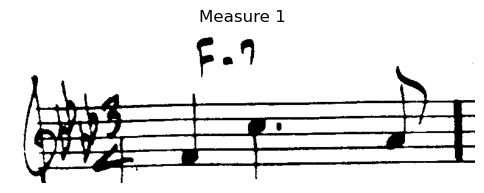

Measure 1 (page1):
  Prediction: 2 E F
  Ground Truth: "Fm7" F2 c3 A
  Match Percentage: 0.00%
--------------------------------------------------

Processing measure 002 (page1):


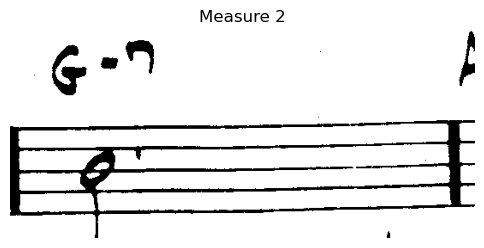

Measure 2 (page1):
  Prediction: c2 c2 c2
  Ground Truth: "G7" B6
  Match Percentage: 0.00%
--------------------------------------------------

Processing measure 003 (page1):


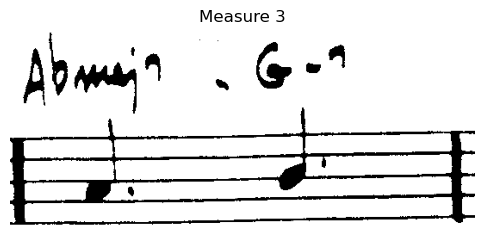

Measure 3 (page1):
  Prediction: c2 c2 c2
  Ground Truth: "Abmaj7" A3"Gm7" B3
  Match Percentage: 0.00%
--------------------------------------------------

Processing measure 004 (page1):


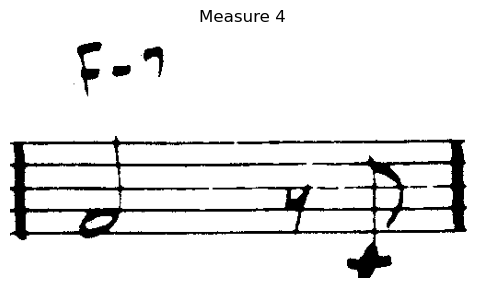

Measure 4 (page1):
  Prediction: c2 c2 c2
  Ground Truth: "Fm7" F4 z C
  Match Percentage: 0.00%
--------------------------------------------------

Processing measure 005 (page1):


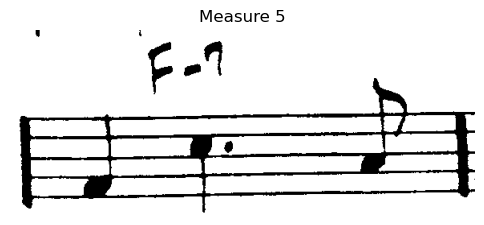

Measure 5 (page1):
  Prediction: c2 c2 c2
  Ground Truth: "Fm7" F2 c3 A
  Match Percentage: 0.00%
--------------------------------------------------

Processing measure 006 (page1):


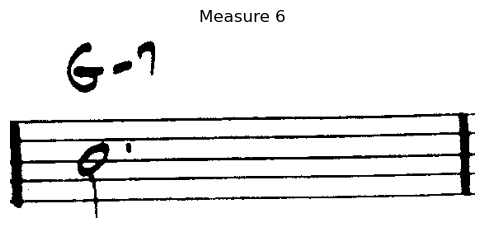

Measure 6 (page1):
  Prediction: 2 G2 G2
  Ground Truth: "G7" B6
  Match Percentage: 16.67%
--------------------------------------------------

Processing measure 007 (page1):


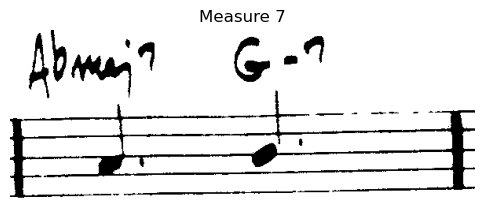

Measure 7 (page1):
  Prediction: A2 A2 A2
  Ground Truth: "Abmaj7" A3"Gm7" B3
  Match Percentage: 0.00%
--------------------------------------------------

Processing measure 008 (page1):


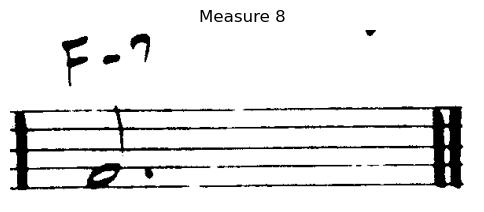

Measure 8 (page1):
  Prediction: A2 A2
  Ground Truth: "Fm7" F6
  Match Percentage: 0.00%
--------------------------------------------------

Processing measure 009 (page1):


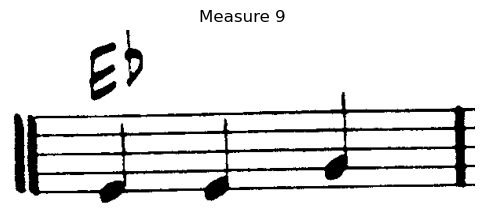

Measure 9 (page1):
  Prediction: F2 F2 F2
  Ground Truth: "Eb" E2 E2 G2
  Match Percentage: 10.00%
--------------------------------------------------

Processing measure 010 (page1):


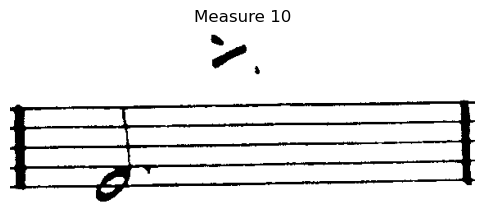

Measure 10 (page1):
  Prediction: E2 E2 E2
  Ground Truth: E6
  Match Percentage: 16.67%
--------------------------------------------------

Processed 10 measures for Afro-Blue
Average match percentage: 4.33%


[{'measure': 1,
  'page': 'page1',
  'path': 'Data/measures_pngs/Afro-Blue/final_measures/measure_001_page1.png',
  'prediction': '2 E F',
  'ground_truth': '"Fm7" F2 c3 A',
  'match_percentage': 0.0},
 {'measure': 2,
  'page': 'page1',
  'path': 'Data/measures_pngs/Afro-Blue/final_measures/measure_002_page1.png',
  'prediction': 'c2 c2 c2',
  'ground_truth': '"G7" B6',
  'match_percentage': 0.0},
 {'measure': 3,
  'page': 'page1',
  'path': 'Data/measures_pngs/Afro-Blue/final_measures/measure_003_page1.png',
  'prediction': 'c2 c2 c2',
  'ground_truth': '"Abmaj7" A3"Gm7" B3',
  'match_percentage': 0.0},
 {'measure': 4,
  'page': 'page1',
  'path': 'Data/measures_pngs/Afro-Blue/final_measures/measure_004_page1.png',
  'prediction': 'c2 c2 c2',
  'ground_truth': '"Fm7" F4 z C',
  'match_percentage': 0.0},
 {'measure': 5,
  'page': 'page1',
  'path': 'Data/measures_pngs/Afro-Blue/final_measures/measure_005_page1.png',
  'prediction': 'c2 c2 c2',
  'ground_truth': '"Fm7" F2 c3 A',
  'matc

In [12]:
# Batch prediction for a song with TensorBoard logging
predict_measures_for_song(song_name="Afro-Blue", start_measure=1, end_measure=10, use_writer=True)

In [15]:
def test_tokenizer(tokenizer, input_texts):
    """
    Test the tokenizer on various ABC notation examples
    and print detailed analysis of the tokenization.
    """
    print("=== T5 Tokenizer Test ===")
    print(f"Vocabulary size: {len(tokenizer)}")
    print(f"Special tokens: {tokenizer.all_special_tokens}\n")
    
    for i, text in enumerate(input_texts):
        # Tokenize the text
        tokens = tokenizer.tokenize(text)
        token_ids = tokenizer.encode(text)
        decoded = tokenizer.decode(token_ids)
        
        # Print results
        print(f"Example {i+1}: {text}")
        print(f"Tokens: {tokens}")
        print(f"Token IDs: {token_ids}")
        print(f"# of tokens: {len(tokens)}")
        print(f"Decoded: {decoded}")
        print("-" * 50)
    
    # Test some specific ABC notation elements
    print("\n=== Testing ABC Elements ===")
    abc_elements = [
        # Test chords
        '"Cmaj7"', '"Fm7"', '"G7b9"',
        # Test notes with durations
        'A2', 'B4', 'C8',
        # Test modifiers
        '^F', '_B', '=C',
        # Test complex patterns
        '"Dm7" A2 B4', '|:', 'z2'
    ]
    
    for element in abc_elements:
        tokens = tokenizer.tokenize(element)
        print(f"{element}: {tokens} ({len(tokens)} tokens)")
    
    # Check how many tokens for a typical ABC measure
    sample_measure = '"Ebmaj7" G"Eb7" G"Ab6" F E/F/'
    tokens = tokenizer.tokenize(sample_measure)
    print(f"\nSample measure: {sample_measure}")
    print(f"Tokenized as: {tokens}")
    print(f"Token count: {len(tokens)}")

# Run the test with some example ABC notation
abc_examples = [
    # Simple examples
    'c4',
    '"Fm7" F2 c3 A',
    # More complex examples
    '"Ebmaj7" G"Eb7" G"Ab6" F E/F/',
    # Check if special chords are single tokens
    '"Dm7b5" c2"G7" d2'
]

test_tokenizer(t5_tokenizer, abc_examples)

=== T5 Tokenizer Test ===
Vocabulary size: 32684
Special tokens: ['</s>', '<unk>', '<pad>', '"Ee7"', '"Gm7/C"', '"Dm9"', '"E7#9"', '"Cmaj13"', '"C#m7/F#"', '"Dbm7"', '"Ebm/Db"', '"A/C#"', '"D7b9b5"', '"G7#9b5"', '"Cmdj7"', '"E+"', '"A7b9"', '"A7#9#5"', '"Bb7b5"', '"Bb9/F"', '"E7#5"', '"C9#5"', '"Em9"', '"Dsus2"', '"E/G"', '"Am11"', '"Bb/Ab"', '"Gm"', '"E/G#"', '"E9"', '"Abm2/Db"', '"EBm7"', '"Gmaj9"', '"Am9"', '"Bm"', '"D7b9#9b5#5"', '"E743/B"', '"Ddim7"', '"Ab6"', '"Bb"', '"E6"', '"F6/A"', '"Eb"', '"Cc7"', '"Bmaj7"', '"De7"', '"Amaj7"', '"Bbmaj/Eb"', '"G+7"', '"Dm69"', '"Am7b5/Eb"', '"Bbm6"', '"Am6"', '"Db7/F"', '"F7b9#5"', '"Fm7/Ab"', '"Db9#11"', '"Gbmaj13#11"', '"Am7/D"', '"D7#9"', '"Fc7"', '"F943"', '"Gbdim#7"', '"Cm69"', '"F7b5"', '"Cm7e5"', '"Abm6"', '"Am7e5"', '"Gm7/F"', '"^A"', '"Cbmaj9#11"', '"E7#11"', '"Bbm7b5/Ab"', '"Cb7"', '"C7/Bb"', '"GB7"', '"Bmdj7"', '"C13"', '"C69"', '"Bm11"', '"Dm7/C"', '"Ebm7"', '"C9"', '"Ab9#11"', '"E7b5"', '"Dmaj"', '"Cdim"', '"Eb7/Bb"', '"G7#5"', '

In [14]:
print('hi')

hi
